<a href="https://colab.research.google.com/github/evysb/Tutorial_Detectron2/blob/main/Detectron2_infernece_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15837, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 15837 (delta 30), reused 12 (delta 12), pack-reused 15781 (from 2)
Receiving objects: 100% (15837/15837), 6.40 MiB | 10.78 MiB/s, done.
Resolving deltas: 100% (11537/11537), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import sys
# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
import matplotlib.pyplot as plt
#from kora.drive import upload_public
from IPython.display import HTML
def show_image(img):
  plt.figure(figsize=(10,10))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

Inferencia em uma imagem
1. Baixar uma imagem de exemplo
2. abrir imagem usando cv2
3. mostrar imagem

--2025-02-19 18:45:27--  http://images.cocodataset.org/val2017/000000439715.jpg
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.36.177, 52.217.126.169, 3.5.11.202, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.36.177|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209222 (204K) [image/jpeg]
Saving to: ‘input.jpg’

input.jpg           100%[===================>] 204.32K   825KB/s    in 0.2s    

2025-02-19 18:45:27 (825 KB/s) - ‘input.jpg’ saved [209222/209222]



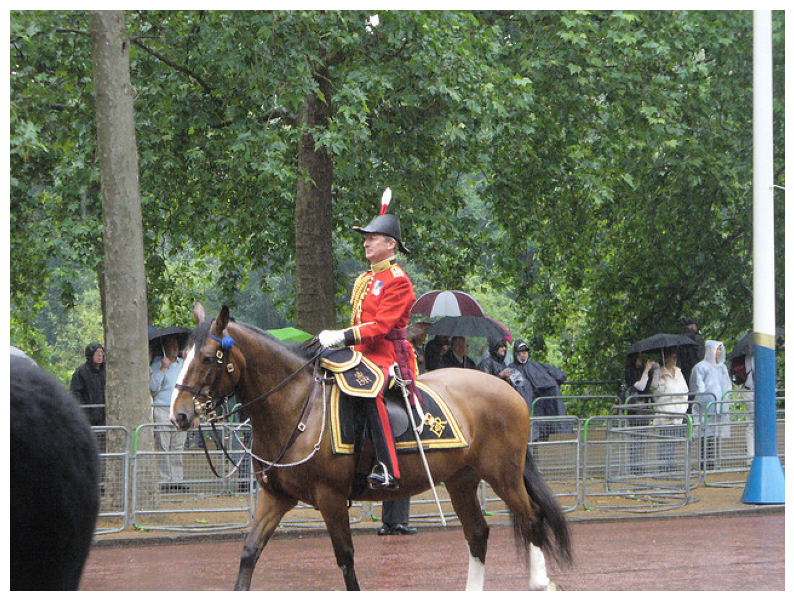

In [4]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -O input.jpg

im = cv2.imread("./input.jpg")
show_image(im[:,:,::-1])

Configuração e definição do modelo:

In [5]:
cfg = get_cfg()
config_file="COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_file))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_file)  # Let training initialize from model zoo
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[02/19 18:45:31 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:02, 79.2MB/s]                           
/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
metadata

namespace(name='coco_2017_train',
          json_file='datasets/coco/annotations/instances_train2017.json',
          image_root='datasets/coco/train2017',
          evaluator_type='coco',
          thing_dataset_id_to_contiguous_id={1: 0,
                                             2: 1,
                                             3: 2,
                                             4: 3,
                                             5: 4,
                                             6: 5,
                                             7: 6,
                                             8: 7,
                                             9: 8,
                                             10: 9,
                                             11: 10,
                                             13: 11,
                                             14: 12,
                                             15: 13,
                                             16: 14,
                                   

In [7]:
classes = outputs["instances"].pred_classes.cpu().numpy()
masks = outputs['instances'].pred_masks.cpu().numpy()
boxes = outputs['instances'].pred_boxes.tensor.cpu().numpy()
[metadata.thing_classes[c] for c in classes]

['horse',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'umbrella',
 'person',
 'umbrella',
 'umbrella',
 'person',
 'person',
 'backpack']

Visualização de resultado:

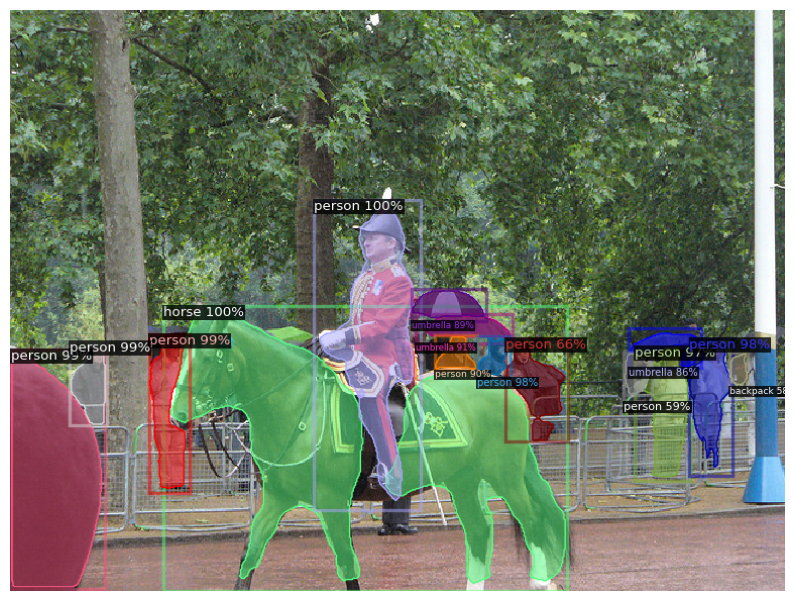

In [8]:
v = Visualizer(im[:, :, ::-1], metadata, scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
show_image(v.get_image())

# Camera Test

In [9]:
#TODO:  USAR CODE SNIPPETS (CAMERA CAPTURE)
#TODO: REALIZAR INFERENCIA

In [10]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [11]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

NotAllowedError: Permission denied


# Video Test

Se apresenta um código que abre um vídeo e itera sobre todos os frames. Utiliza-se este código base para implemtar a inferência sobre um vídeo.

https://www.pexels.com/video/cars-on-highway-854671/

In [12]:
video_input='Cars On Highway(3).mp4'
video_output='inference.mp4'

# Configuration input video
cap = cv2.VideoCapture(video_input)
frame_width, frame_height = (640,480)
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Configuration output video
fourcc =cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter(video_output,fourcc, 20.0, (frame_width, frame_height))

cfg = get_cfg()
config_file="COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_file))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_file)  # Let training initialize from model zoo
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
predictor = DefaultPredictor(cfg)


for id_frame in tqdm(range(0,num_frames,10)):
  cap.set(cv2.CAP_PROP_POS_FRAMES,id_frame)
  flag, frame = cap.read()

  if flag:
    frame = cv2.resize(frame, (frame_width, frame_height))
    outputs = predictor(frame)
    v = Visualizer(im[:, :, ::-1], metadata, scale=1.2)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    show_image(v.get_image())

    out_frame = # TODO: VISUALIZACAO

    out.write(out_frame[:,:,::-1].astype('uint8'))

cap.release()
out.release()

SyntaxError: invalid syntax (<ipython-input-12-fc0670e16da5>, line 33)